In [1]:
!. /vol/cuda/11.4.120-cudnn8.2.4/setup.sh
! nvcc --version

/bin/bash: nvcc: command not found


In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.config import config

config.update("jax_enable_x64", True)
%matplotlib inline

In [2]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)

X.shape, y.shape, X_m.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (30, 1), (1000, 1), (1000, 1))

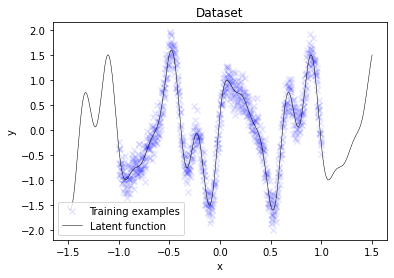

In [3]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [4]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP

model = FCN
model_params = dict(
    nonlinearity=stax.Erf
)

snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1)

snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

2022-07-08 19:54:30.566581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib


(DeviceArray(-1264.75594335, dtype=float64),
 DeviceArray(-1135.12660885, dtype=float64),
 DeviceArray(129.62933451, dtype=float64))

In [5]:
opt_params = snngp.optimize()
snngp.lower_bound(), snngp.upper_bound(), snngp.evaluate()

/vol/bitbucket/yn621/envs/individual-project/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fx = np.asarray(fx).item()


ValueError: The user-provided objective function must return a scalar value.

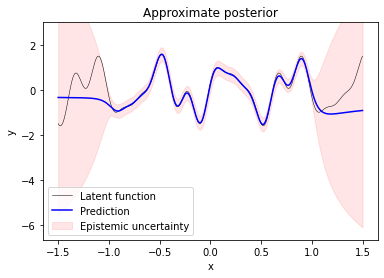

In [6]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

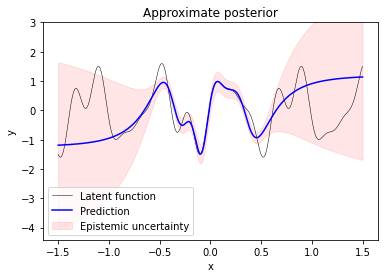

In [7]:
# f_test, f_test_cov = snngp.predict1(X_test, opt_params)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)

# plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
# plt.plot(X_test, f_test, label='Prediction', c='b')
# plt.fill_between(X_test.ravel(), 
#                  f_test.ravel() + 2 * f_test_std, 
#                  f_test.ravel() - 2 * f_test_std,
#                  label='Epistemic uncertainty',
#                  color='r', alpha=0.1)
# plt.title('Approximate posterior')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.ylim(None, 3.0)
# plt.legend()

In [9]:
var = np.array([[1,2],[3,4]])
var1 = var[None, ...]
var1 = np.tile(var1, [3, 1, 1])
var, var1

(array([[1, 2],
        [3, 4]]),
 array([[[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]]]))

In [10]:
var.shape, var[None, ...].shape, var1.shape

((2, 2), (1, 2, 2), (3, 2, 2))

In [14]:
np.diag(var)[:, None].shape, np.tile(np.diag(var)[:, None], [1, 3]).shape

((2, 1), (2, 3))